# SIS with spatial probability contraints

>**Note** this notebook is ispired by the notebook [ex_geosclassic_indicator_2d.ipynb](https://github.com/randlab/geone/blob/master/examples/ex_geosclassic_indicator_2d.ipynb) by Julien Straubhaar


When you want to reproduce the spatial distribution of some indicator variables, one can have access to some additional information, like the proportion of facies is some available lithological logs, or similar information about the proportions.  
For example, from the results of some field surveys that the proportion of facies `1` is 10%, the proportion of facies `2` is 20% and the proportion of the remainder facies `3` is 70%. This information can be included in SIS to obtain simulation that try to reproduce this proportions.

In this notebook we will demonstrate the usage of SIS when some contraints on the total proportions are available.

As usual, the details that were explained in the previous notebooks are omitted for the sake of brievity.

Fist of all, we ned to install the required modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# import package 'geone'
import geone as gn

Second, the number of categories to be simulated should be defined.

## Define probabilities

As mentioned in the introduction, information about the global proportion of the facies can be provided. This is the main difference from the previous notebook.

In [2]:
category_values = [1., 2., 3.]
ncategory = len(category_values)

Then define some colors for the plots.

In [3]:
#categCol = ['lightblue', 'orange', 'darkgreen']
categCol = ['#1b9e77', '#d95f02', '#7570b3'] # see https://colorbrewer2.org for other suggestions
cmap_categ = [gn.customcolors.custom_cmap(['white', c]) for c in categCol]

Same variogram model as the previous example.

In [4]:
cov_model = gn.covModel.CovModel2D(elem=[
    ('exponential', {'w':9., 'r':[150, 40]}), # elementary contribution
    ], alpha=-30, name='model-2D example')

Simulation grid.

In [5]:
nx, ny = 220, 230  # number of cells
dx, dy = 1.0, 1.0  # cell unit
ox, oy = 0.0, 0.0  # origin

dimension = (nx, ny)
spacing = (dx, dy)
origin = (ox, oy)

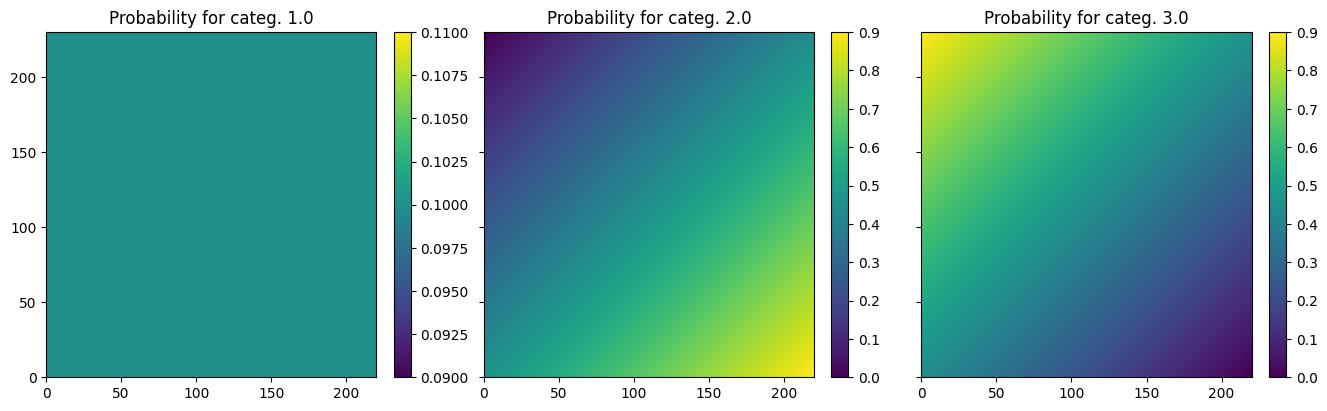

In [6]:
# Set an image with simulation grid geometry defined above, and no variable
im = gn.img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=0)

# Get the x and y coordinates of the centers of grid cell (meshgrid)
xx = im.xx()[0]
yy = im.yy()[0]

# Equivalent:
## xg, yg: coordinates of the centers of grid cell
#xg = ox + 0.5*dx + dx*np.arange(nx)
#yg = oy + 0.5*dy + dy*np.arange(ny)
#xx, yy = np.meshgrid(xg, yg) # create meshgrid from the center of grid cells

# Define probability maps for each category
c = 0.9
p1 = xx - yy     
p1 = c * (p1 - np.min(p1))/ (np.max(p1) - np.min(p1))
p2 = c - p1
p0 = (1. - c) * np.ones_like(p1) # 1.0 - p1 - p2 # constant map (0.1)

probability = np.array((p0, p1, p2))

# Set variable p0, p1, p2 in image im
im.append_var(probability, varname=['p0', 'p1', 'p2'])

# Display 
plt.subplots(1, 3, figsize=(16,12), sharey=True)

for i in range(ncategory):
    plt.subplot(1, 3, 1+i)
    gn.imgplot.drawImage2D(im, iv=i, title = 'Probability for categ. {}'.format(category_values[i]))

plt.show()

In [7]:
x = np.array([[ 10.,  20.], # 1st point
              [ 50.,  40.], # 2nd point
              [ 20., 150.], # 3rd point
              [200., 210.]]) # 4th point
v = [ 1., 2., 1., 3.] # values

## Simulation

Here we apply the SIS method with global probability constraints. The main change here is that the argument `probability` is explicitly provided (if this is omitted, facies proportions are computed from the conditioning data, but in this case we only have few).

In [8]:
nreal = 10
np.random.seed(321)

geosclassic_output = gn.geosclassicinterface.simulateIndicator2D(
    category_values, cov_model, dimension, spacing, origin, 
    x=x, v=v, probability=probability, nreal=nreal, nthreads=1)


Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 1 thread(s)]
Geos-Classic run complete


## Collect results and plot

In [9]:
# Retrieve the realizations
simul = geosclassic_output['image']

# Compute proportion of each category (pixel-wise)
simul_prop = gn.img.imageCategProp(simul, category_values)

Hereinafter the plots

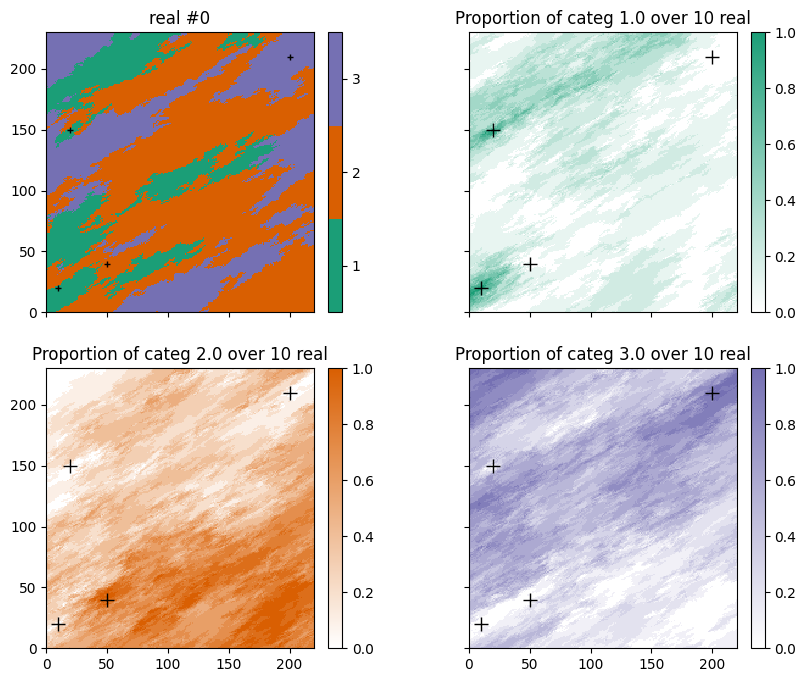

In [10]:
# Plot
plt.subplots(2, 2, figsize=(10,8), sharex=True, sharey=True)

plt.subplot(2,2,1)
gn.imgplot.drawImage2D(simul, iv=2, categ=True, categCol=categCol, title='real #0')
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations

for i in range(ncategory):
    plt.subplot(2,2,2+i)
    gn.imgplot.drawImage2D(simul_prop, iv=i, vmin=0, vmax=1, cmap=cmap_categ[i], 
                           title='Proportion of categ {0} over {1} real'.format(category_values[i], nreal))
    plt.plot(x[:,0],x[:,1], '+', c='black', markersize=10) # add conditioning point locations

## Check the proportions

To double check, we can verify if the proportions are well represented. Whe already have access to the proportions for each category, but let's check on one realization.

In [11]:
# Select the realization number (should be <nreal)
real_sel = 2
# Proportion for facies 1
prop1 = np.sum(simul.val[real_sel,:,:,:] == 1)/(220*230)
# Proportion for facies 2
prop2 = np.sum(simul.val[real_sel,:,:,:] == 2)/(220*230)
# Proportion for facies 3
prop3 = np.sum(simul.val[real_sel,:,:,:] == 3)/(220*230)

print("Realization #{0}".format(real_sel))
print("facies 1 proportions: {0:.2f} (target: {1:.2f})".format(prop1, probability[0]))
print("facies 2 proportions: {0:.2f} (target: {1:.2f})".format(prop2, probability[1]))
print("facies 3 proportions: {0:.2f} (target: {1:.2f})".format(prop3, probability[2]))

Realization #2


TypeError: unsupported format string passed to numpy.ndarray.__format__

## Try yourself

- If you want, change the value of `real_sel` to see how the proportions are represented in other realizations.
- Try also changing the target proportions (the list `probability`).